# Artificially Conscious Entity Ironic Test

Author: Shanel Gauthier
Date: 2021-12-09

The task consists of classifying three skin disease types from skin images. The three classes are “acne”, “herpes simplex”, and “lichen planus”. 

In [5]:
%pip install timm
%pip install mlflow --quiet
%pip install -q gwpy

     |████████████████████████████████| 376 kB 13.1 MB/s 
     |████████████████████████████████| 15.5 MB 11.8 MB/s 
     |████████████████████████████████| 79 kB 8.2 MB/s 
     |████████████████████████████████| 1.1 MB 47.9 MB/s 
     |████████████████████████████████| 58 kB 5.9 MB/s 
     |████████████████████████████████| 180 kB 49.4 MB/s 
     |████████████████████████████████| 146 kB 51.6 MB/s 
     |████████████████████████████████| 596 kB 41.2 MB/s 
     |████████████████████████████████| 75 kB 4.6 MB/s 
     |████████████████████████████████| 53 kB 1.9 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
     |████████████████████████████████| 1.4 MB 10.7 MB/s 
     |████████████████████████████████| 11.2 MB 38.4 MB/s 
     |████████████████████████████████| 51 kB 6.9 MB/s 
     |████████████████████████████████| 884 kB 43.3 MB/s 
     |████████████████████████████████| 55 kB 3.3 MB/s 
     |████████████████████████████████| 3.6 MB 38.6 MB/s 
ERROR: pip's dependency re

In [6]:
#clone parametric scattering network repo
! git clone https://github.com/sgaut023/kymatio_mod/

Cloning into 'kymatio_mod'...
remote: Enumerating objects: 9863, done.
remote: Counting objects: 100% (2185/2185), done.
remote: Compressing objects: 100% (767/767), done.
remote: Total 9863 (delta 1541), reused 2001 (delta 1413), pack-reused 7678
Receiving objects: 100% (9863/9863), 1.00 GiB | 29.20 MiB/s, done.
Resolving deltas: 100% (4274/4274), done.


In [7]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from getpass import getpass
from sklearn.metrics import classification_report
from torchvision import models
from pprint import pprint

import time
import torch.nn as nn
import pandas as pd
import IPython
import numpy as np
import seaborn as sn
import mlflow
import os
import matplotlib.pyplot as plt
import sklearn.utils.class_weight as class_weight
import datetime
import copy
import timm
import warnings
warnings.filterwarnings("ignore")


For this experiment, we are using an experimental tracking tool: Mlflow. We need to set the environement variables first. 
**Set Environment Variables**

In [8]:
#@title Enter the repository name for the project:

REPO_NAME= "skin_disease_tracking" #@param {type:"string"}

In [9]:
#@title Enter the repository name for the project:

REPO_OWNER= "gauthier.shanel" #@param {type:"string"}

In [10]:
#@title Enter the username of your DAGsHub account:

USER_NAME = "gauthier.shane" #@param {type:"string"}

**Set Local Configurations**

Under the [Token tab](https://dagshub.com/user/settings/tokens) in the user setting, copy the default token and use it here.

In [11]:
os.environ['MLFLOW_TRACKING_USERNAME'] = USER_NAME
os.environ['MLFLOW_TRACKING_PASSWORD'] = getpass('Enter your DAGsHub access token or password: ')
mlflow.set_tracking_uri(f'https://dagshub.com/{REPO_OWNER}/{REPO_NAME}.mlflow')

Enter your DAGsHub access token or password: ··········


In [12]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [13]:
%cd gdrive/MyDrive/Jobs/

/content/gdrive/MyDrive/Jobs


In [14]:
from pathlib import Path 
import sys
sys.path.append(str(Path.cwd())+ '/kymatio_mod/')
from kymatio_mod.parametricSN.models.sn_base_models import sn_ScatteringBase
from kymatio_mod.parametricSN.models.sn_top_models import sn_LinearLayer,sn_CNN
from kymatio_mod.parametricSN.models.sn_hybrid_models import sn_HybridModel

# 1. Create Pytorch Dataset

In this section, we create the pytorch Dataset and dataloader.

In [15]:
#Settings and hyperparamerters for this experiment
batch_size = 2
workers = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
def augmentationFactory(augmentation):

  if augmentation == 'augment':
        transform = [
            transforms.Resize((400,400)),
            transforms.RandomHorizontalFlip(),
        ]

  elif augmentation == 'noaugment':
          transform = [
            transforms.Resize((400,400)),
        ]

  else: 
      NotImplemented(f"augment parameter {augmentation} not implemented")

  normalize = transforms.Normalize(mean=[0.6475, 0.4907, 0.4165],
                                     std=[0.1875, 0.1598, 0.1460])

  return transforms.Compose(transform + [transforms.ToTensor()])                 #, normalize])       


In [17]:
# Create Dataset
dataset = datasets.ImageFolder(root='data_3class_skin_diseases/', transform=augmentationFactory('augment'))

In the dataloader, we normalize the images by the mean and std per channel. Below, you can see how we computed the mean and std per channel.

Mean: [0.6475, 0.4907, 0.4165]
std: [0.1875, 0.1598, 0.1460]

In [18]:
# code from: https://stackoverflow.com/questions/60101240/finding-mean-and-standard-deviation-across-image-channels-pytorch
def get_mean_std_per_channel(loader):
    nimages = 0
    mean = 0.
    std = 0.
    for batch, _ in loader:
        batch = batch.view(batch.size(0), batch.size(1), -1)
        # Update total number of images
        nimages += batch.size(0)
        mean += batch.mean(2).sum(0) 
        std += batch.std(2).sum(0)

    # Final step
    mean /= nimages
    std /= nimages
    return mean, std
# create dataloader
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers,pin_memory=True)
get_mean_std_per_channel(loader)

(tensor([0.6475, 0.4907, 0.4165]), tensor([0.1882, 0.1607, 0.1470]))

# 2. Training Utils

In this section, we implement the functions that will be used to train de different models.

In [19]:
def get_loaders(dataset, train_ids, test_ids, batch_size):
  # Sample elements randomly from a given list of ids, no replacement.
  train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
  test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
  # Define data loaders for training and testing data in this fold
  trainloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_subsampler)
  testloader = torch.utils.data.DataLoader( dataset,batch_size=batch_size, sampler=test_subsampler)
  return trainloader, testloader, train_subsampler

In [20]:
def get_loss_function(dataset, trainloader, indices):
  #Compute class weight of the classes
  class_weights=class_weight.compute_class_weight('balanced', classes= np.unique(dataset.targets), 
                                                  y = np.array(trainloader.dataset.targets)[indices] )
  class_weights=torch.tensor(class_weights,dtype=torch.float).to(device)
  return nn.CrossEntropyLoss(weight=class_weights,reduction='mean')

In [21]:
def get_confusion_matrix(y_true, y_pred):
  matrix = confusion_matrix(y_true, y_pred)
  index = np.arange(0, len(matrix), 1)
  df_cm = pd.DataFrame(matrix, index=index, columns=index)
  f = plt.figure()
  sn.heatmap(df_cm, annot=True)
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.show()

In [22]:
def visualize_loss(train_loss, test_loss):
  f = plt.figure(figsize=(7,5))
  epochs = np.arange(0, len(train_loss))
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.plot( epochs, train_loss, label='Train' )
  plt.plot( epochs, test_loss, label= 'Test' )
  plt.legend()
  plt.show()

In [23]:
def evaluate_model(network, testloader, loss_function):
  correct, total = 0, 0
  with torch.no_grad():

    y_pred = []
    y_true = []
    for i, data in enumerate(testloader, 0):

      # Get inputs
      inputs, targets = data
      inputs = inputs.to(device)
      targets = targets.to(device)

      # Generate outputs
      outputs = network(inputs)
      loss = loss_function(outputs, targets)  

      # Set total and correct
      _, predicted = torch.max(outputs.data, 1)
      y_pred.extend(predicted.cpu().numpy())
      y_true.extend(targets.cpu().numpy())
  return loss, y_pred, y_true

In [24]:
def save_results(results, fold, y_pred, y_true):  
  results[fold]={}
  results[fold]['pred'] = y_pred
  results[fold]['label']= y_true
  results[fold]['classification_report']=classification_report(y_true, y_pred, output_dict=True)

In [25]:
def setAllSeeds(seed):
    """Helper for setting seeds"""
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)

In [31]:
def train_model(name, dataset, k_folds =5, num_epochs =15, lr =1e-4, random_state=42):
  # code isnpired from: https://www.machinecurve.com/index.php/2021/02/03/how-to-use-k-fold-cross-validation-with-pytorch/
  setAllSeeds(random_state)
  kfold = StratifiedKFold(n_splits=k_folds, shuffle = True, random_state=random_state)
  results = {}
  start_time = time.time()
  for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset, dataset.targets)):
      print(f'FOLD {fold}')
      print('--------------------------------')
      network = get_model(name)
      network.to(device)
      trainloader, testloader, train_subsampler =get_loaders(dataset, train_ids, test_ids, batch_size)
      loss_function = get_loss_function(dataset, trainloader, train_subsampler.indices)
      optimizer = torch.optim.SGD(network.parameters(), lr=lr)
      
      # Run the training loop for defined number of epochs
      train_loss = []
      test_loss= []
      for epoch in range(0, num_epochs):
        current_loss = 0.0
        # Iterate over the DataLoader for training data
        for i, data in enumerate(trainloader, 0):

          inputs, targets = data
          inputs = inputs.to(device)
          targets = targets.to(device)
          optimizer.zero_grad()
          
          outputs = network(inputs)
          #print(outputs.shape)
          loss = loss_function(outputs, targets)  
          loss.backward()   
          optimizer.step()
          
          # Print statistics
          current_loss += loss.item()
        train_loss.append(current_loss/(i+1))
        loss, y_pred, y_true = evaluate_model(network,testloader, loss_function)
        test_loss.append(loss)
        print(f'Epoch {epoch+1}-- Train Loss:{current_loss/(i+1)}, Test Loss: {loss}')
      
      visualize_loss(train_loss, test_loss) 
      get_confusion_matrix(y_true, y_pred)
      print('Starting testing')
      loss, y_pred, y_true = evaluate_model(network,testloader, loss_function)
      save_results(results, fold, y_pred, y_true)
  
  total_time = time.time() - start_time
  avg_time_fold = total_time/k_folds
  results['total_time'] =total_time
  results['avg_time_fold']= avg_time_fold
  results['trainable_parameters'] = sum(p.numel() for p in network.parameters() if p.requires_grad)
  print('Training Complete')
  return results
    

In [27]:
def get_avg_classification_report(results, k_folds=5):
  # create average classification report of all reports
  # make a copy of a classification reports
  avg_report = copy.deepcopy(results[0]['classification_report'])
  for key in avg_report:
    for sub_key in ['precision', 'recall', 'f1-score']:
      values = []
      is_subkey = True
      for fold in np.arange(0,k_folds):
        try:
          values.append(results[fold]['classification_report'][key][sub_key])
        except:
            values.append(results[fold]['classification_report'][key])
            is_subkey = False
      mean = np.array(values).mean()
      std = np.array(values).std()
      if is_subkey:
          avg_report[key][sub_key] = f'{mean.round(3)}±{std.round(3)}'
      else:
          avg_report[key] = f'{mean.round(3)}±{std.round(3)}'
  return avg_report
    


In [28]:
def save_metrics_mlflow(name, report, results ):
  # log metrics and parameters into MLflow
  with mlflow.start_run(run_name = 'skin_disease_performance'):
      mlflow.log_param('model', name)
      mlflow.log_param('total_time',results['total_time'] )
      mlflow.log_param('avg_time_fold',results['avg_time_fold'] )
      mlflow.log_param('trainable_parameters', results['trainable_parameters'])
      for key in report:
        for sub_key in ['precision', 'recall', 'f1-score']:
          try:
              values = report[key][sub_key].split('±')
              mlflow.log_metric(f'{key}-{sub_key}-avg',float(values[0]))
              mlflow.log_metric(f'{key}-{sub_key}-std',float(values[1]))

          except:
            values = report[key].split('±')
            mlflow.log_metric(f'{key}-avg', float(values[0]))
            mlflow.log_metric(f'{key}-std', float(values[1]))

# 3. Model Definition



## 3.1 Vanilla CNN

As a baseline, let's implement a vanilla Convolutional Neural Network with 3 layers.

In [48]:
# vanilla cnn architecture from: https://www.analyticsvidhya.com/blog/2019/10/building-image-classification-models-cnn-pytorch/
class Net(nn.Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Defining a 2D convolution layer
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            nn.Conv2d(16, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Defining thirs 2D convolution layer
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = nn.Sequential(
            nn.Linear(320000, 3)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

## 3.2 Pretained Resnet-50

In [49]:
class Resnet50(nn.Module):
    """
    Pretrained model on ImageNet
    Architecture: ResNet-50
    """
    def __init__(self, num_classes=3):
        super(Resnet50, self).__init__()
        self.model_ft = models.resnet50(pretrained=True)
        num_ftrs = self.model_ft.fc.in_features
        self.model_ft.fc =  nn.Linear(num_ftrs, num_classes)
        self.num_classes = num_classes

    def forward(self, x):
        x = self.model_ft(x)
        return x

## 3.3 Big Transfer (BiT)

The model was proposed in this paper: https://arxiv.org/abs/1912.11370

To finetune the model, we just need to run this command: 


> network = timm.create_model('resnetv2_101x1_bitm', pretrained=True, num_classes=NUM_FINETUNE_CLASSES)



## 3.4 Parametric Scattering Network

In [29]:
%%capture
def get_model(name):
  if name =='cnn':
    network = Net()
  elif name =='resnet50':
    network =  Resnet50(num_classes=3)
  elif name =='bit':
    network = timm.create_model('resnetv2_101x1_bitm', pretrained=True, num_classes=3)
  elif name=='scattering':
    scatteringBase = sn_ScatteringBase(J=3, N=400, M=400, second_order=False, initialization='Tight-Frame', seed=42, 
                                       learnable=True, lr_orientation=0.1, lr_scattering=0.1, monitor_filters=True,
                                       filter_video=False, parameterization='canonical')
    ll_net = sn_LinearLayer(num_classes=3, n_coefficients=217, M_coefficient=50, N_coefficient=50)
    network = sn_HybridModel(scatteringBase=scatteringBase, top=ll_net ).to(device) #creat hybrid model
  else: 
      NotImplemented(f"Model Architecture {name} not implemented")
  return network



# 4. Training

## 4.1 Vanilla CNN

FOLD 0
--------------------------------
Epoch 1-- Train Loss:1.9302255539223552, Test Loss: 2.7263336181640625
Epoch 2-- Train Loss:3.6687013705571494, Test Loss: 8.388630867004395
Epoch 3-- Train Loss:4.167307384001712, Test Loss: 3.0124754905700684
Epoch 4-- Train Loss:0.7656428863604864, Test Loss: 2.927263021469116
Epoch 5-- Train Loss:1.2195287154366572, Test Loss: 0.753200352191925
Epoch 6-- Train Loss:0.320108400657773, Test Loss: 2.3840675354003906
Epoch 7-- Train Loss:0.3217606625209252, Test Loss: 1.5246549844741821
Epoch 8-- Train Loss:0.22397457241701582, Test Loss: 0.19356217980384827
Epoch 9-- Train Loss:0.16997035577272376, Test Loss: 2.2362804412841797
Epoch 10-- Train Loss:0.2686333718399207, Test Loss: 0.5848729610443115
Epoch 11-- Train Loss:0.17170015970865884, Test Loss: 0.7885991334915161
Epoch 12-- Train Loss:0.2861771621586134, Test Loss: 0.4852316975593567
Epoch 13-- Train Loss:0.4715971238911152, Test Loss: 18.697425842285156
Epoch 14-- Train Loss:2.5778839501

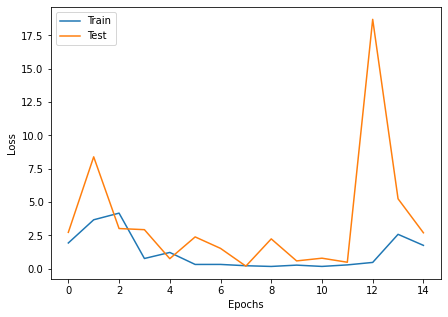

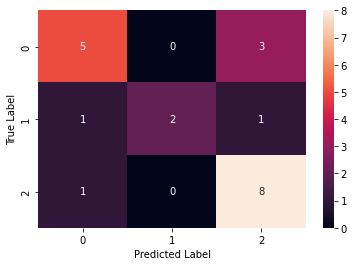

Starting testing
FOLD 1
--------------------------------
Epoch 1-- Train Loss:2.031571681300799, Test Loss: 8.253089904785156
Epoch 2-- Train Loss:2.961899975169217, Test Loss: 1.322117567062378
Epoch 3-- Train Loss:0.8927592247103652, Test Loss: 1.7977622747421265
Epoch 4-- Train Loss:0.6633561750253042, Test Loss: 6.600422382354736
Epoch 5-- Train Loss:1.2516884170472622, Test Loss: 1.6481963396072388
Epoch 6-- Train Loss:0.9770779063304266, Test Loss: 5.514314651489258
Epoch 7-- Train Loss:1.965775685229649, Test Loss: 4.331526756286621
Epoch 8-- Train Loss:0.4289046546631046, Test Loss: 3.523625135421753
Epoch 9-- Train Loss:0.32535731109479943, Test Loss: 0.6939418315887451
Epoch 10-- Train Loss:0.3905835871895154, Test Loss: 8.757230758666992
Epoch 11-- Train Loss:1.5631329673924483, Test Loss: 0.45670607686042786
Epoch 12-- Train Loss:0.1706309299916029, Test Loss: 0.09017643332481384
Epoch 13-- Train Loss:0.37653390566507977, Test Loss: 6.639159679412842
Epoch 14-- Train Loss:1

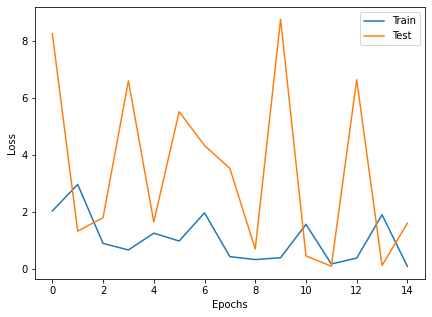

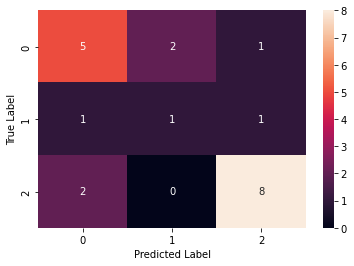

Starting testing
FOLD 2
--------------------------------
Epoch 1-- Train Loss:2.001073961456617, Test Loss: 0.719361424446106
Epoch 2-- Train Loss:3.939625302950541, Test Loss: 2.5317373275756836
Epoch 3-- Train Loss:1.623863697052002, Test Loss: 4.596627712249756
Epoch 4-- Train Loss:2.0580470779289803, Test Loss: 3.270758628845215
Epoch 5-- Train Loss:0.6228584734102091, Test Loss: 2.884535551071167
Epoch 6-- Train Loss:1.0116295218467712, Test Loss: 0.08430715650320053
Epoch 7-- Train Loss:1.2508994340896606, Test Loss: 0.4755973517894745
Epoch 8-- Train Loss:0.2756658134361108, Test Loss: 1.2601078748703003
Epoch 9-- Train Loss:0.3424775586463511, Test Loss: 0.654672384262085
Epoch 10-- Train Loss:0.1580051276832819, Test Loss: 1.0228978395462036
Epoch 11-- Train Loss:0.10764447289208572, Test Loss: 0.3073018789291382
Epoch 12-- Train Loss:0.14866694062948227, Test Loss: 0.06730536371469498
Epoch 13-- Train Loss:0.06984566214183967, Test Loss: 0.8389186859130859
Epoch 14-- Train Lo

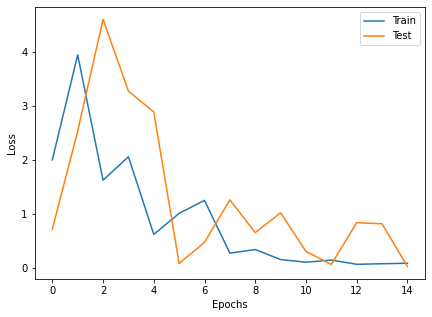

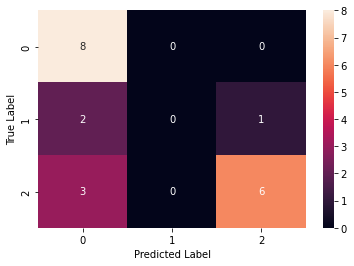

Starting testing
FOLD 3
--------------------------------
Epoch 1-- Train Loss:1.9951877395311992, Test Loss: 18.90956687927246
Epoch 2-- Train Loss:4.989049861828486, Test Loss: 3.6771020889282227
Epoch 3-- Train Loss:3.521846355870366, Test Loss: 5.778017520904541
Epoch 4-- Train Loss:2.087265898784002, Test Loss: 5.950347900390625
Epoch 5-- Train Loss:1.6052158946792285, Test Loss: 0.2982262372970581
Epoch 6-- Train Loss:0.45840487132469815, Test Loss: 8.430184364318848
Epoch 7-- Train Loss:1.2131073325872421, Test Loss: 1.2293751239776611
Epoch 8-- Train Loss:0.2587498376766841, Test Loss: 0.5508822202682495
Epoch 9-- Train Loss:0.4835599834720294, Test Loss: 2.0905420780181885
Epoch 10-- Train Loss:0.9804420042783022, Test Loss: 1.636975884437561
Epoch 11-- Train Loss:0.9435346921284994, Test Loss: 1.1273138523101807
Epoch 12-- Train Loss:0.529276041003565, Test Loss: 0.36504435539245605
Epoch 13-- Train Loss:0.10544822041022901, Test Loss: 0.3185674548149109
Epoch 14-- Train Loss:

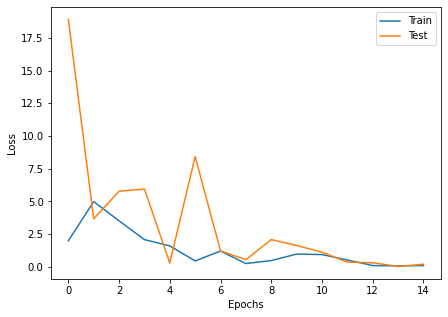

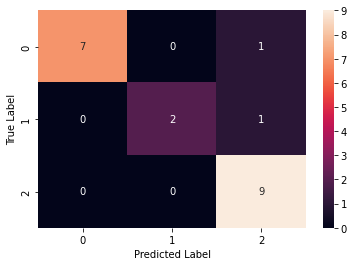

Starting testing
FOLD 4
--------------------------------
Epoch 1-- Train Loss:1.0285483598709106, Test Loss: 2.77053165435791
Epoch 2-- Train Loss:2.1224354406197867, Test Loss: 0.10030507296323776
Epoch 3-- Train Loss:2.448802481094996, Test Loss: 9.864729881286621
Epoch 4-- Train Loss:1.4761163517832756, Test Loss: 0.5070999264717102
Epoch 5-- Train Loss:0.605171856780847, Test Loss: 6.110284805297852
Epoch 6-- Train Loss:0.5809995191423999, Test Loss: 3.1779263019561768
Epoch 7-- Train Loss:0.2626904353188972, Test Loss: 3.082136869430542
Epoch 8-- Train Loss:0.21201417098442712, Test Loss: 4.037818908691406
Epoch 9-- Train Loss:0.11099628234903018, Test Loss: 1.7738656997680664
Epoch 10-- Train Loss:0.12943358051901063, Test Loss: 0.03478534519672394
Epoch 11-- Train Loss:0.12302575757106145, Test Loss: 2.489558458328247
Epoch 12-- Train Loss:0.11185983257989089, Test Loss: 1.1915587186813354
Epoch 13-- Train Loss:0.0657657707342878, Test Loss: 0.5494806170463562
Epoch 14-- Train L

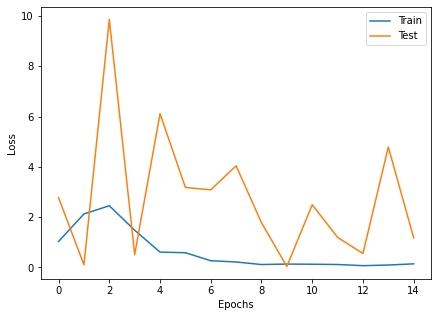

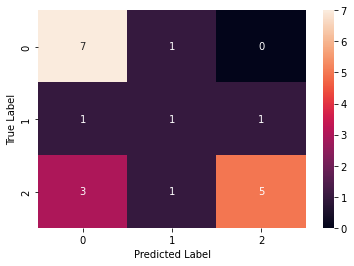

Starting testing
Training Complete


TypeError: ignored

In [79]:
# Init the neural network
name ='cnn'
results = train_model(name=name, dataset=dataset, k_folds =5, num_epochs =15)
report = get_avg_classification_report(results, k_folds =5)
pprint(report)
save_metrics_mlflow(name, report, results )

## 4.2 Petrained Resnet-50

FOLD 0
--------------------------------
Epoch 1-- Train Loss:1.1552059402068455, Test Loss: 1.5773873329162598
Epoch 2-- Train Loss:1.2199355959892273, Test Loss: 0.7842989563941956
Epoch 3-- Train Loss:1.207847148180008, Test Loss: 1.772190809249878
Epoch 4-- Train Loss:0.9964358061552048, Test Loss: 1.477467656135559
Epoch 5-- Train Loss:0.7339423547188441, Test Loss: 3.004611015319824
Epoch 6-- Train Loss:0.7613955388466517, Test Loss: 2.631871461868286
Epoch 7-- Train Loss:0.8759956806898117, Test Loss: 3.2001521587371826
Epoch 8-- Train Loss:0.5969287989040216, Test Loss: 0.8977571129798889
Epoch 9-- Train Loss:0.7052410542964935, Test Loss: 1.257295846939087
Epoch 10-- Train Loss:0.7719160591562589, Test Loss: 1.249552845954895
Epoch 11-- Train Loss:0.34315348230302334, Test Loss: 2.285273790359497
Epoch 12-- Train Loss:0.5932879584530989, Test Loss: 0.8030757308006287
Epoch 13-- Train Loss:0.48037700975934666, Test Loss: 1.4409316778182983
Epoch 14-- Train Loss:0.162326937851806

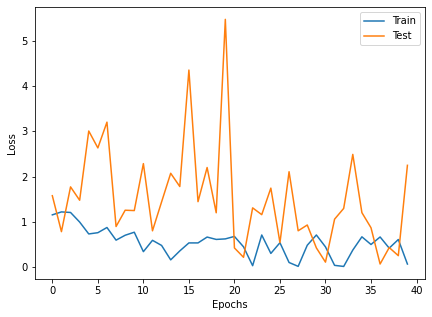

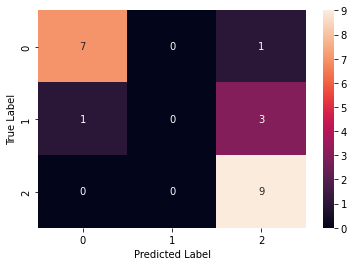

Starting testing
FOLD 1
--------------------------------
Epoch 1-- Train Loss:1.1522786219914753, Test Loss: 4.108448028564453
Epoch 2-- Train Loss:1.3714955747127533, Test Loss: 2.4999589920043945
Epoch 3-- Train Loss:1.0568099617958069, Test Loss: 2.1937994956970215
Epoch 4-- Train Loss:0.9147372245788574, Test Loss: 2.332498073577881
Epoch 5-- Train Loss:0.9507962713638941, Test Loss: 1.960741639137268
Epoch 6-- Train Loss:0.5867656071980795, Test Loss: 3.0999574661254883
Epoch 7-- Train Loss:0.5907006114721298, Test Loss: 2.421116590499878
Epoch 8-- Train Loss:0.5958140206833681, Test Loss: 1.565506100654602
Epoch 9-- Train Loss:0.3856602720916271, Test Loss: 1.4059014320373535
Epoch 10-- Train Loss:0.36646269758542377, Test Loss: 0.939315676689148
Epoch 11-- Train Loss:0.3248448309799035, Test Loss: 0.06630073487758636
Epoch 12-- Train Loss:0.5663529696563879, Test Loss: 1.218536138534546
Epoch 13-- Train Loss:0.3700662963092327, Test Loss: 0.04203329235315323
Epoch 14-- Train Los

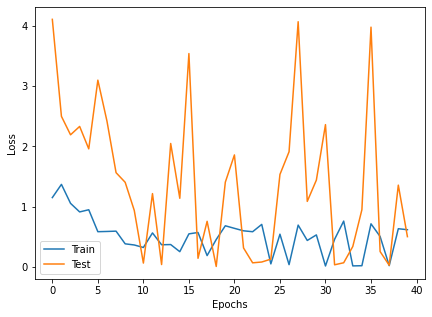

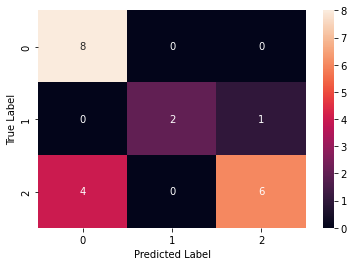

Starting testing
FOLD 2
--------------------------------
Epoch 1-- Train Loss:1.2803809543450673, Test Loss: 3.7149548530578613
Epoch 2-- Train Loss:1.272212564945221, Test Loss: 1.3584282398223877
Epoch 3-- Train Loss:0.7912688056627909, Test Loss: 1.4261773824691772
Epoch 4-- Train Loss:1.0371930698553722, Test Loss: 1.3596782684326172
Epoch 5-- Train Loss:0.6862437079350153, Test Loss: 1.7018457651138306
Epoch 6-- Train Loss:0.7765850275754929, Test Loss: 1.3921715021133423
Epoch 7-- Train Loss:0.48451003432273865, Test Loss: 1.1082398891448975
Epoch 8-- Train Loss:0.42219754060109455, Test Loss: 0.38976916670799255
Epoch 9-- Train Loss:0.21548578018943468, Test Loss: 1.0600336790084839
Epoch 10-- Train Loss:0.32859816153844196, Test Loss: 3.006136417388916
Epoch 11-- Train Loss:0.31438424189885456, Test Loss: 1.551045536994934
Epoch 12-- Train Loss:0.20692641908923784, Test Loss: 0.0668945237994194
Epoch 13-- Train Loss:0.10665603540837765, Test Loss: 2.05330491065979
Epoch 14-- Tr

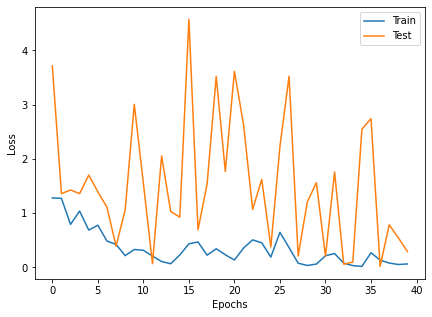

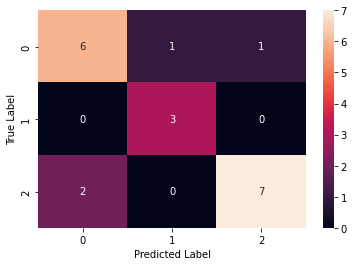

Starting testing
FOLD 3
--------------------------------
Epoch 1-- Train Loss:1.2227382858594258, Test Loss: 2.243175983428955
Epoch 2-- Train Loss:1.2257497708002727, Test Loss: 1.243774652481079
Epoch 3-- Train Loss:0.9505500197410583, Test Loss: 1.457934021949768
Epoch 4-- Train Loss:0.663499558965365, Test Loss: 2.0468122959136963
Epoch 5-- Train Loss:0.8229666302601496, Test Loss: 0.7406333684921265
Epoch 6-- Train Loss:0.5059425681829453, Test Loss: 2.1541354656219482
Epoch 7-- Train Loss:0.38671065618594486, Test Loss: 1.4627070426940918
Epoch 8-- Train Loss:0.19390412668387094, Test Loss: 0.6904865503311157
Epoch 9-- Train Loss:0.2076505422592163, Test Loss: 0.13461974263191223
Epoch 10-- Train Loss:0.2733411242564519, Test Loss: 0.6444407105445862
Epoch 11-- Train Loss:0.23494935035705566, Test Loss: 0.14643511176109314
Epoch 12-- Train Loss:0.11417997131745021, Test Loss: 0.3949047029018402
Epoch 13-- Train Loss:0.08444822207093239, Test Loss: 0.1115645244717598
Epoch 14-- Tr

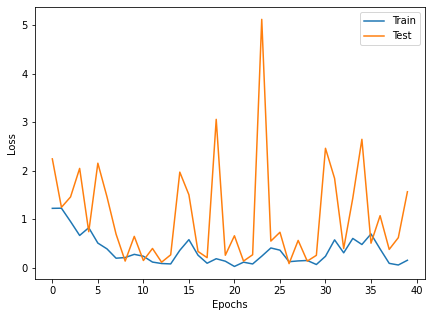

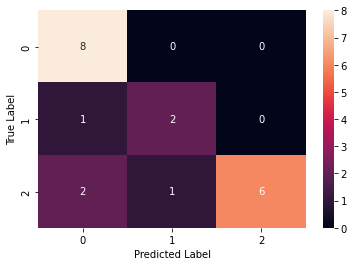

Starting testing
FOLD 4
--------------------------------
Epoch 1-- Train Loss:1.1059828599294026, Test Loss: 3.1971309185028076
Epoch 2-- Train Loss:0.9628656208515167, Test Loss: 0.9165142178535461
Epoch 3-- Train Loss:1.1862081289291382, Test Loss: 0.868672251701355
Epoch 4-- Train Loss:0.727194940050443, Test Loss: 2.0157625675201416
Epoch 5-- Train Loss:0.6183409343163172, Test Loss: 3.612492084503174
Epoch 6-- Train Loss:0.6598080148299535, Test Loss: 0.8963363766670227
Epoch 7-- Train Loss:0.5452289655804634, Test Loss: 1.7356131076812744
Epoch 8-- Train Loss:0.5676229645808538, Test Loss: 1.6416345834732056
Epoch 9-- Train Loss:0.40435593699415523, Test Loss: 3.3399667739868164
Epoch 10-- Train Loss:0.7541861894230047, Test Loss: 3.5933923721313477
Epoch 11-- Train Loss:0.3394515533000231, Test Loss: 0.42035725712776184
Epoch 12-- Train Loss:0.12330772417287032, Test Loss: 1.2599669694900513
Epoch 13-- Train Loss:0.11995506752282381, Test Loss: 1.473470687866211
Epoch 14-- Train

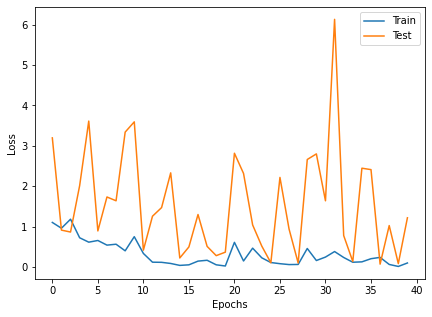

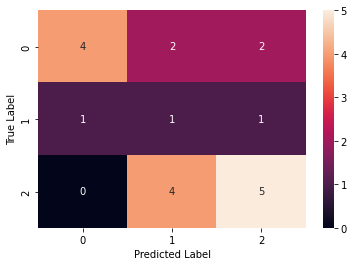

Starting testing
Training Complete
{'0': {'f1-score': '0.822±0.108',
       'precision': '0.826±0.103',
       'recall': '0.85±0.184',
       'support': 8},
 '1': {'f1-score': '0.563±0.228',
       'precision': '0.682±0.316',
       'recall': '0.583±0.269',
       'support': 4},
 '2': {'f1-score': '0.818±0.065',
       'precision': '0.888±0.138',
       'recall': '0.782±0.122',
       'support': 9},
 'accuracy': '0.773±0.114',
 'macro avg': {'f1-score': '0.734±0.122',
               'precision': '0.799±0.125',
               'recall': '0.739±0.132',
               'support': 21},
 'weighted avg': {'f1-score': '0.778±0.097',
                  'precision': '0.835±0.08',
                  'recall': '0.773±0.114',
                  'support': 21}}


In [91]:
results = train_model('resnet50', dataset, k_folds =5, lr= 1e-2, num_epochs =40)
pprint(get_avg_classification_report(results))

## 4.3 Big Transfer (BiT)



FOLD 0
--------------------------------
Epoch 1-- Train Loss:11.775977611541748, Test Loss: 11.0304594039917
Epoch 2-- Train Loss:2.709562656780084, Test Loss: 5.566081523895264
Epoch 3-- Train Loss:1.6874410510063171, Test Loss: 1.6207242012023926
Epoch 4-- Train Loss:1.332649141550064, Test Loss: 1.2408698797225952
Epoch 5-- Train Loss:1.3024285435676575, Test Loss: 2.086946964263916
Epoch 6-- Train Loss:1.286445418993632, Test Loss: 1.1415350437164307
Epoch 7-- Train Loss:1.1453705628712971, Test Loss: 1.6062034368515015
Epoch 8-- Train Loss:1.1460692485173543, Test Loss: 1.3179200887680054
Epoch 9-- Train Loss:1.1666036148866017, Test Loss: 0.6664367318153381
Epoch 10-- Train Loss:1.1168161630630493, Test Loss: 1.2593897581100464
Epoch 11-- Train Loss:1.11172949274381, Test Loss: 1.7061094045639038
Epoch 12-- Train Loss:1.2420744895935059, Test Loss: 3.8449995517730713
Epoch 13-- Train Loss:1.5372849305470784, Test Loss: 0.9056503176689148
Epoch 14-- Train Loss:1.151396115620931, T

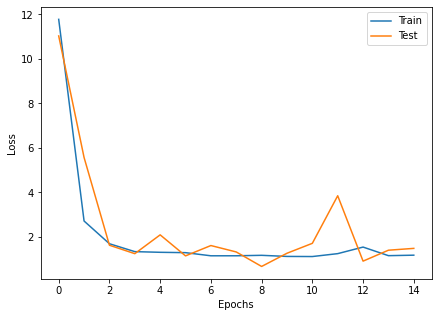

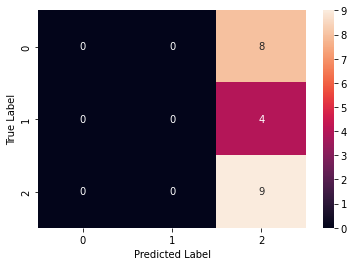

Starting testing
FOLD 1
--------------------------------
Epoch 1-- Train Loss:10.402669986089071, Test Loss: 2.726612091064453
Epoch 2-- Train Loss:1.4793538550535839, Test Loss: 2.290105104446411
Epoch 3-- Train Loss:1.5638125737508137, Test Loss: 3.637298583984375
Epoch 4-- Train Loss:1.3497264981269836, Test Loss: 3.157658100128174
Epoch 5-- Train Loss:1.2972939213116963, Test Loss: 1.0469520092010498
Epoch 6-- Train Loss:1.1848472952842712, Test Loss: 1.4106982946395874
Epoch 7-- Train Loss:1.1615699728329976, Test Loss: 0.6080425381660461
Epoch 8-- Train Loss:1.1080105702082317, Test Loss: 1.2201143503189087
Epoch 9-- Train Loss:1.2016373872756958, Test Loss: 1.2906193733215332
Epoch 10-- Train Loss:1.2892288863658905, Test Loss: 1.5926356315612793
Epoch 11-- Train Loss:0.9805319905281067, Test Loss: 5.481149196624756
Epoch 12-- Train Loss:2.2393171787261963, Test Loss: 2.56330943107605
Epoch 13-- Train Loss:1.241416573524475, Test Loss: 2.2179439067840576
Epoch 14-- Train Loss:1.

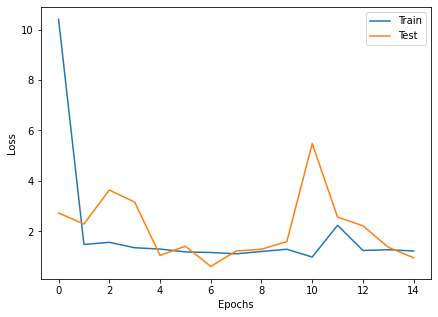

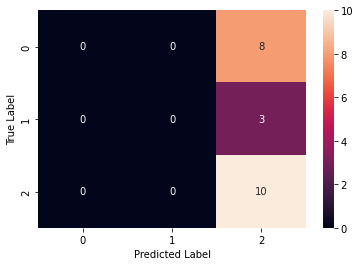

Starting testing
FOLD 2
--------------------------------
Epoch 1-- Train Loss:7.1078446706136065, Test Loss: 9.423452377319336
Epoch 2-- Train Loss:2.19940451780955, Test Loss: 1.0707385540008545
Epoch 3-- Train Loss:1.1530226866404216, Test Loss: 0.8151155710220337
Epoch 4-- Train Loss:1.4512632290522258, Test Loss: 2.199100971221924
Epoch 5-- Train Loss:1.2397018571694691, Test Loss: 1.4077975749969482
Epoch 6-- Train Loss:1.1682878533999126, Test Loss: 1.7788740396499634
Epoch 7-- Train Loss:1.1425901254018147, Test Loss: 1.2627471685409546
Epoch 8-- Train Loss:1.0838724672794342, Test Loss: 1.2910966873168945
Epoch 9-- Train Loss:1.1205779910087585, Test Loss: 0.10364175587892532
Epoch 10-- Train Loss:1.2579017877578735, Test Loss: 1.953705072402954
Epoch 11-- Train Loss:1.185879647731781, Test Loss: 0.897240400314331
Epoch 12-- Train Loss:1.1130129098892212, Test Loss: 0.8527920842170715
Epoch 13-- Train Loss:1.0884342392285664, Test Loss: 0.882172167301178
Epoch 14-- Train Loss:1

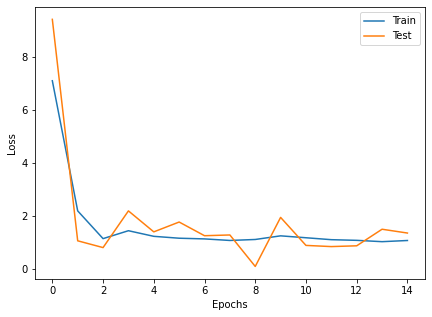

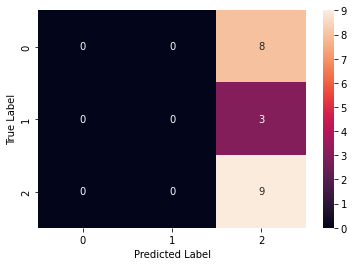

Starting testing
FOLD 3
--------------------------------
Epoch 1-- Train Loss:6.049527625242869, Test Loss: 3.6332414150238037
Epoch 2-- Train Loss:1.6190269589424133, Test Loss: 1.328351378440857
Epoch 3-- Train Loss:1.355808675289154, Test Loss: 1.322584867477417
Epoch 4-- Train Loss:1.218142181634903, Test Loss: 1.2068703174591064
Epoch 5-- Train Loss:1.192595899105072, Test Loss: 1.2373954057693481
Epoch 6-- Train Loss:1.2322404781977336, Test Loss: 2.238577127456665
Epoch 7-- Train Loss:1.118493676185608, Test Loss: 0.9771248698234558
Epoch 8-- Train Loss:1.1385643581549327, Test Loss: 1.6105422973632812
Epoch 9-- Train Loss:1.1249039769172668, Test Loss: 1.965460181236267
Epoch 10-- Train Loss:1.1415423154830933, Test Loss: 0.7398309707641602
Epoch 11-- Train Loss:1.1436110933621724, Test Loss: 1.1239526271820068
Epoch 12-- Train Loss:0.9918181697527567, Test Loss: 0.6997783780097961
Epoch 13-- Train Loss:1.0444214741388957, Test Loss: 1.3083219528198242
Epoch 14-- Train Loss:0.8

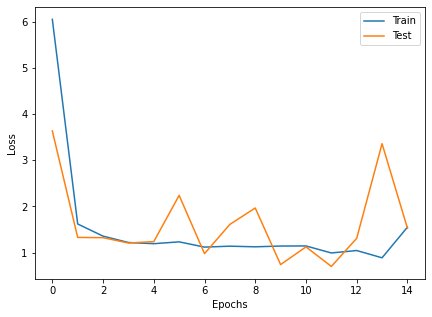

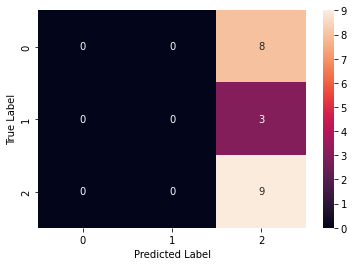

Starting testing
FOLD 4
--------------------------------
Epoch 1-- Train Loss:6.958781202634175, Test Loss: 0.7142295837402344
Epoch 2-- Train Loss:1.2016919751962025, Test Loss: 3.074575662612915
Epoch 3-- Train Loss:1.4728697538375854, Test Loss: 1.667126178741455
Epoch 4-- Train Loss:1.1110550065835316, Test Loss: 0.7094592452049255
Epoch 5-- Train Loss:1.2442679405212402, Test Loss: 2.2626726627349854
Epoch 6-- Train Loss:1.2826907833417256, Test Loss: 0.7236154079437256
Epoch 7-- Train Loss:0.9525842269261678, Test Loss: 1.4748977422714233
Epoch 8-- Train Loss:1.11797696352005, Test Loss: 0.5449693202972412
Epoch 9-- Train Loss:0.902603934208552, Test Loss: 2.461350679397583
Epoch 10-- Train Loss:0.8407662610212961, Test Loss: 0.665482759475708
Epoch 11-- Train Loss:0.7397363980611166, Test Loss: 0.5271692872047424
Epoch 12-- Train Loss:0.6866273880004883, Test Loss: 1.7079907655715942
Epoch 13-- Train Loss:0.4135832066337268, Test Loss: 0.5581909418106079
Epoch 14-- Train Loss:0.

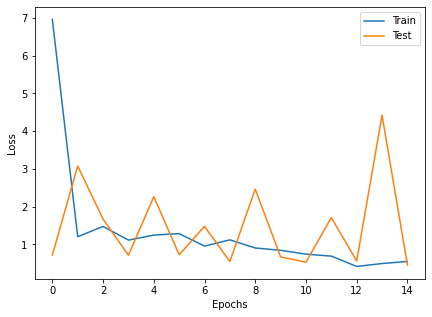

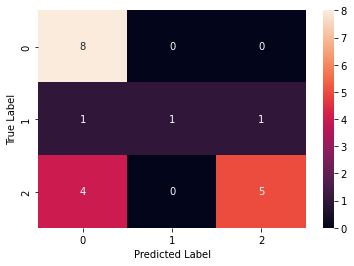

Starting testing
Training Complete
{'0': {'f1-score': '0.152±0.305',
       'precision': '0.123±0.246',
       'recall': '0.2±0.4',
       'support': 8},
 '1': {'f1-score': '0.1±0.2',
       'precision': '0.2±0.4',
       'recall': '0.067±0.133',
       'support': 4},
 '2': {'f1-score': '0.631±0.023',
       'precision': '0.528±0.154',
       'recall': '0.911±0.178',
       'support': 9},
 'accuracy': '0.501±0.101',
 'macro avg': {'f1-score': '0.294±0.174',
               'precision': '0.284±0.266',
               'recall': '0.393±0.119',
               'support': 21},
 'weighted avg': {'f1-score': '0.361±0.16',
                  'precision': '0.317±0.227',
                  'recall': '0.501±0.101',
                  'support': 21}}


In [92]:
results = train_model( 'bit', dataset, k_folds =5, lr= 1e-2, num_epochs =15)
pprint(get_avg_classification_report(results))

## 4.4 Parametric Scattering Network

In [30]:
results = train_model( 'scattering', dataset, k_folds =5, lr= 1e-2, num_epochs =15)
pprint(get_avg_classification_report(results))

FOLD 0
--------------------------------
torch.Size([2, 3])
torch.Size([2, 3])
torch.Size([2, 3])
torch.Size([2, 3])
torch.Size([2, 3])
torch.Size([2, 3])
torch.Size([2, 3])
torch.Size([2, 3])
torch.Size([2, 3])
torch.Size([2, 3])
torch.Size([2, 3])
torch.Size([2, 3])
torch.Size([2, 3])
torch.Size([2, 3])
torch.Size([2, 3])
torch.Size([2, 3])
torch.Size([2, 3])
torch.Size([2, 3])
torch.Size([2, 3])
torch.Size([2, 3])
torch.Size([2, 3])
torch.Size([2, 3])
torch.Size([2, 3])
torch.Size([2, 3])
torch.Size([2, 3])
torch.Size([2, 3])
torch.Size([2, 3])
torch.Size([2, 3])
torch.Size([2, 3])
torch.Size([2, 3])
torch.Size([2, 3])
torch.Size([2, 3])
torch.Size([2, 3])
torch.Size([2, 3])
torch.Size([2, 3])
torch.Size([2, 3])
torch.Size([2, 3])
torch.Size([2, 3])
torch.Size([2, 3])
torch.Size([2, 3])
torch.Size([1, 3])
Epoch 1-- Train Loss:53.376762292116396, Test Loss: 76.59104919433594
torch.Size([2, 3])
torch.Size([2, 3])
torch.Size([2, 3])
torch.Size([2, 3])
torch.Size([2, 3])
torch.Size([2, 3

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-30-29787b1b7e87>", line 1, in <module>
    results = train_model( 'scattering', dataset, k_folds =5, lr= 1e-2, num_epochs =15)
  File "<ipython-input-26-1d1b244efc0c>", line 29, in train_model
    outputs = network(inputs)
  File "/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py", line 1102, in _call_impl
    return forward_call(*input, **kwargs)
  File "/content/gdrive/MyDrive/Jobs/kymatio_mod/parametricSN/models/sn_hybrid_models.py", line 32, in forward
    return self.top(self.scatteringBase(inp))
  File "/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py", line 1120, in _call_impl
    result = forward_call(*input, **kwargs)
  File "/content/gdrive/MyDrive/Jobs/kymatio_mod/kymatio/frontend/torch_frontend.py", line 23, in forward
    retur

KeyboardInterrupt: ignored

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f5cd99c85f0> (for post_execute):


KeyboardInterrupt: ignored

ImportError: ignored

<Figure size 1440x720 with 40 Axes>

ImportError: ignored

<Figure size 1440x720 with 40 Axes>

ImportError: ignored

<Figure size 1440x720 with 40 Axes>

## 5. Access Metrics using Mlflow and DAGsHub

In [88]:
display(IPython.display.IFrame(f"https://dagshub.com/{REPO_OWNER}/{REPO_NAME}/experiments/#/",'100%',600))